#**CSIE5732 Computer Vision, NTU, TPE**
[Homework2](http://cv2.csie.ntu.edu.tw/CV/hw2019/hw2.html)


>Deadline : 2022-09-27

> Hello TA, the colab file can be found in the [URL](https://colab.research.google.com/drive/1fNkXrYuPeOtbdrgg3TaDBlo1FRFy_hVL?usp=sharing)





##Description:
###Write a program to generate:
*   (a) a binary image (threshold at 128)
*   (b) a histogram
*   (c) connected components
(regions with + at centroid,
bounding box)

###Announcement
*   You may use any programming language of your choice to implement the functions required in assignment #2, provided that you do not use any library calls except for basic image IO (e.g. OpenCV).
*   Binarize Lena with the threshold 128 (0-127,128-255).
*   You have to draw the histogram. The part where you calculate the histogram must be done hardcored, but you may output your statistics data to a file and use auxiliary program to assist you in drawing the bar graphs, i.e., Excel, gnuplot, sigmaplot, matplotlib, matlab.
*   For the connected components, please use 500 pixels as a threshold. Omit regions that have a pixel count less than 500.

*   Grading policy
    * Failing to provide a report will reduce your grade by 1~2 levels.
    * Using restricted functions within your program (unless specified) will result in a failure of your work.
*   Hint: You can use any programing language to implement homework. However don't just call libraries, if just call libraries you will get zero point.
You may use any programming language of your choice to implement the functions required in assignment #2, provided that you do not use any library calls except for basic image IO (e.g. OpenCV).






###**FAQ**
*   Q1: 畫十字、bounding box的部分可否直接call library?
>可以哦。 e.g. cv2.rectangle
標示重心也可以用其他圖案標示像是實心圓等圖案，不一定要用十字，標示清楚即可。
*   Q2: Conneted components 要用四連通還是八連通?
>兩者皆可。惟報告需註明你用的是哪一種連通方式。
*   Q3: 有規定報告的頁數嗎?
>沒有，但建議不要超過4頁。報告內容簡短扼要即可。
*   Q4: (c)的結果圖bounding box 應該會有幾個?
>無論是4連通、8連通都是五個bounding box，請繳交之前再次確認。
如果你的結果不是五個應該是你的程式寫錯或是你用面積500以外的數值來過濾conneted component。
*   Q5: 畫十字在重心是要依照第三周教的那個方法畫在所有相同label的重心，還是畫在框住相同label的最小矩形正中間即可?
>相同label之重心，不是矩形正中間。
*   Q6: 第三題找出 connected components 所用的圖，是否就是用第一小題 threshold=128 的結果?
>是的。




##Step1: Load the Dependencies

> This section loads some required libraries used in this notebook: **numpy**, **cv2**

*   [Numpy](https://www.numpy.org/) is an array manipulation library, used for linear algebra, Fourier transform, and random number capabilities.
*   [CV2](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_gui/py_image_display/py_image_display.html) is a library for computer vision tasks.






In [ ]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage.measurements import label
from google.colab.patches import cv2_imshow # for image display

In [ ]:
s = "12345"
s[::-1]

'54321'

##Step2: define the class for the transformations
> we implement the transformations as the private methods under the classs 'HW2'

In [ ]:
class HW2:
    def __init__(self, dirc, objc):
        self.img    = cv2.imread(dirc+objc,0)
        self.dirc    = dirc
        self.shape  = self.img.shape
        self.nRow  = self.img.shape[0]
        self.nCol   = self.img.shape[1]
        self.label   = np.zeros([self.nRow, self.nCol], dtype=int)

    def original(self):
        return self.img

    def selfdefined_histogram(self):
        histogram = [0] * 256
        for rowIdx in range(self.nRow):
            for colIdx in range(self.nCol):
                histogram[ self.img[rowIdx][colIdx] ] += 1
        return np.array(histogram), np.array(list(range(0,256+1)))

    def numpy_histogram(self):
        histogram, bin_edges = np.histogram( a=self.img, bins=256, range=(0, 256) )
        return histogram, bin_edges

    def binarize(self, thresh, maxval):
        ans = np.zeros(self.shape, int)
        for rowIdx in range(self.nRow):
            for colIdx in range(self.nCol):
                ans[rowIdx, colIdx] = maxval if self.img[ rowIdx, colIdx ] > thresh else 0
        return ans

    # initialization of each 1-pixel to a unique label
    def initializationLabelArray(self):
        count = 1
        for rowIdx in range(self.nRow):
            for colIdx in range(self.nCol):
                if self.img[rowIdx][colIdx] == 255:
                    self.label[rowIdx][colIdx] = count
                    count += 1

    # the value of each nonzero pixel is replaced by the minimum value
    # of its nonzero neighbors in a recursive manner
    # from left to right and top to bottom
    def topDown(self):
        change = False
        print("top down!!!")
        for rowIdx in range(self.nRow):
            for colIdx in range(self.nCol):
                if self.label[rowIdx][colIdx] > 0:
                    # find the minimum among the 4-connected neighbors
                    # condition 1 : index is not out of boundary
                    # condition 2 : neighbor.label > 0 : not background
                    # condition 3 : center.label < neighbor.label
                    # if condition1 and condition 2 and condition 3
                    # then update center.label as neighbor.label
                    if rowIdx>0 and self.label[rowIdx-1][colIdx] > 0 and self.label[rowIdx-1][colIdx] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx-1][colIdx]
                        change = True
                    if rowIdx<self.nRow-1 and self.label[rowIdx+1][colIdx] > 0 and self.label[rowIdx+1][colIdx] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx+1][colIdx]
                        change = True
                    if colIdx>0 and self.label[rowIdx][colIdx-1] > 0 and self.label[rowIdx][colIdx-1] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx][colIdx-1]
                        change = True
                    if colIdx<self.nCol-1 and self.label[rowIdx][colIdx+1] > 0 and self.label[rowIdx][colIdx+1] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx][colIdx+1]
                        change = True
        return change

    # the value of each nonzero pixel is replaced by the minimum value
    # of its nonzero neighbors in a recursive manner
    # from right to left and bottom to up
    def bottomUp(self):
        change = False
        print("buttom up!!!")
        for rowIdx in reversed(range(self.nRow)):
            for colIdx in reversed(range(self.nCol)):
                if self.label[rowIdx][colIdx] > 0:
                    # find the minimum among the 4-connected neighbors
                    # condition 1 : index is not out of boundary
                    # condition 2 : neighbor.label > 0 : not background
                    # condition 3 : center.label < neighbor.label
                    # if condition1 and condition 2 and condition 3
                    # then update center.label as neighbor.label
                    if rowIdx>0 and self.label[rowIdx-1][colIdx] > 0 and self.label[rowIdx-1][colIdx] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx-1][colIdx]
                        change = True
                    if rowIdx<self.nRow-1 and self.label[rowIdx+1][colIdx] > 0 and self.label[rowIdx+1][colIdx] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx+1][colIdx]
                        change = True
                    if colIdx>0 and self.label[rowIdx][colIdx-1] > 0 and self.label[rowIdx][colIdx-1] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx][colIdx-1]
                        change = True
                    if colIdx<self.nCol-1 and self.label[rowIdx][colIdx+1] > 0 and self.label[rowIdx][colIdx+1] < self.label[rowIdx][colIdx]:
                        self.label[rowIdx][colIdx] = self.label[rowIdx][colIdx+1]
                        change = True
        return change

    def iterateAlgorithm(self):
        self.initializationLabelArray()
        # iteration of top-down followed by bottom-up passes
        change = True
        numIteration = 0
        while change:
            numIteration += 1
            print( "Number of iterations = " + str(numIteration) )
            change = False
            change = self.topDown()
            change = self.bottomUp()
        return None

    def calculateArea(self):
        label2Area = dict()
        for rowIdx in range(self.nRow):
            for colIdx in range(self.nCol):
                label = self.label[rowIdx][colIdx]
                if label > 0:
                    if label in label2Area:
                        label2Area[label] += 1
                    else:
                        label2Area[label] = 1
        return label2Area

    def calculateBoundingRectangle(self,class_):
        minRowIdx  = self.nRow
        minColIdx   = self.nCol
        maxRowIdx = -1
        maxColIdx  = -1
        sumRowIdx = 0
        sumColIdx  = 0
        pixelCount = 0
        for rowIdx in range(self.nRow):
            for colIdx in range(self.nCol):
                if self.label[rowIdx][colIdx] == class_:
                    sumRowIdx += rowIdx
                    sumColIdx  += colIdx
                    pixelCount  += 1
                    minRowIdx = min( minRowIdx, rowIdx)
                    minColIdx  = min( minColIdx, colIdx)
                    maxRowIdx = max( maxRowIdx, rowIdx)
                    maxColIdx  = max( maxColIdx, colIdx)
        centroidRowIdx = int (sumRowIdx / pixelCount)
        centroidColIdx  = int (sumColIdx  / pixelCount)
        return minRowIdx, minColIdx, maxRowIdx, maxColIdx, centroidRowIdx, centroidColIdx

    def boundingBox(self):
        img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        area = self.calculateArea()
        for class_, area_ in area.items():
            if area_ > 500:
                blue = (255, 0, 0)
                red = (0, 0, 255)
                thickness = 2

                minRowIdx, minColIdx, maxRowIdx, maxColIdx, centroidRowIdx, centroidColIdx = self.calculateBoundingRectangle(class_)
                start_point = (minColIdx, minRowIdx)
                end_point  = (maxColIdx, maxRowIdx)

                start_point2 = (centroidColIdx-10, centroidRowIdx)
                end_point2  = (centroidColIdx+10, centroidRowIdx)

                start_point3 = (centroidColIdx, centroidRowIdx-10)
                end_point3  = (centroidColIdx, centroidRowIdx+10)

                cv2.rectangle(img, start_point, end_point, blue, thickness)
                cv2.line(img, start_point2, end_point2, red, thickness)
                cv2.line(img, start_point3, end_point3, red, thickness)
        return img

##Step3 Initiate an object from the class constructor

In [ ]:
dir_ = '/content/'
img2 = 'lena.bmp'
obj2 = HW2(dir_,img2)

##Step4: Carry out the transformations

### the orignal image
    

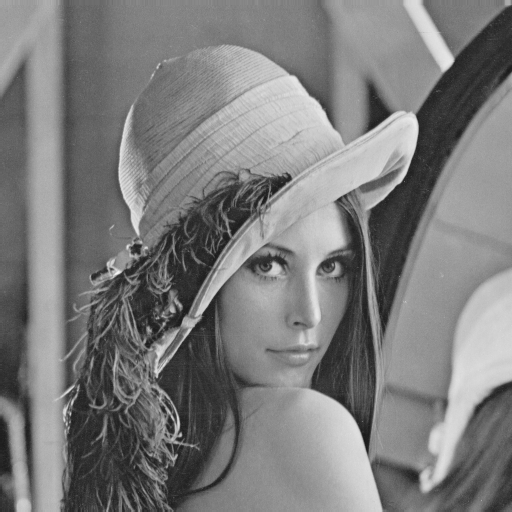

In [ ]:
cv2_imshow(obj2.original())

###(a) a binary image (threshold at 128)
    

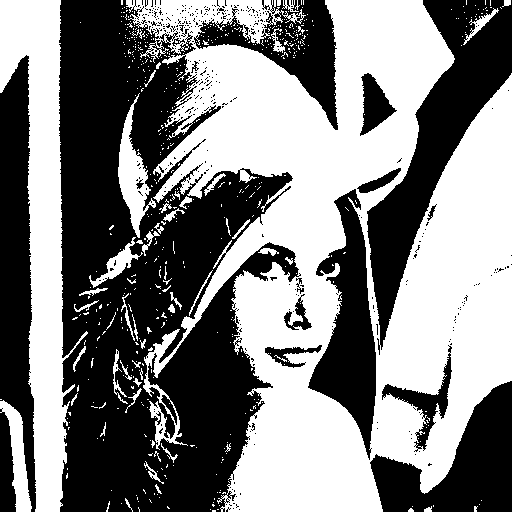

True

In [ ]:
threshold = 128
maxval   = 255
binary_img = obj2.binarize(threshold, maxval)
cv2_imshow(binary_img)
cv2.imwrite('binarized_lena.bmp', binary_img)

###(b) a histogram - [**numpy.histogram**](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)
```python
numpy.histogram(a, bins=10, range=None, normed=None, weights=None, density=None)
```
###Parameters
 - a : array_like
    - Input data.
    - The histogram is computed over the flattened array.

- bins : int or sequence of scalars or str, optional
    - If bins is an int, it defines the number of equal-width bins in the given range (10, by default).


- range(float, float), optional
    - The lower and upper range of the bins.
    - If not provided, range is simply (a.min(), a.max()).
    - Values outside the range are ignored.
    - The first element of the range must be less than or equal to the second.
    - range affects the automatic bin computation as well.
    - While bin width is computed to be optimal based on the actual data within range, the bin count will fill the entire range including portions containing no data.

- weights :  array_like, optional
    - An array of weights, of the same shape as a.
    - Each value in a only contributes its associated weight towards the bin count (instead of 1).
    - If density is True, the weights are normalized, so that the integral of the density over the range remains 1.


 - density : bool, optional
    - If False, the result will contain the number of samples in each bin.
    - If True, the result is the value of the probability density function at the bin, normalized such that the integral over the range is 1.
    - Note that the sum of the histogram values will not be equal to 1 unless bins of unity width are chosen; it is not a probability mass function.
    - Overrides the normed keyword if given.

###Returns
 - hist : array
    - The values of the histogram.
    - See density and weights for a description of the possible semantics.
 - bin_edges : array of dtype float
    - Return the bin edges (length(hist)+1).


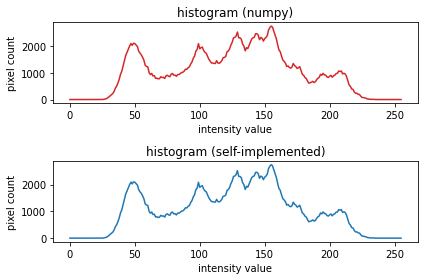

In [ ]:
histogram1, bin_edges1 = obj2.numpy_histogram()
histogram2, bin_edges2 = obj2.selfdefined_histogram()

fig, ax = plt.subplots(2)
ax[0].set_title('histogram (numpy)')
ax[0].set(xlabel="intensity value", ylabel="pixel count")
ax[0].plot(bin_edges1[0:-1], histogram1, 'tab:red')
ax[1].set_title('histogram (self-implemented)')
ax[1].set(xlabel="intensity value", ylabel="pixel count")
ax[1].plot(bin_edges2[0:-1], histogram2)
plt.tight_layout()
plt.show()

### (c) connected components
(regions with + at centroid,
bounding box)
 - Q2: Conneted components 要用四連通還是八連通?
>兩者皆可。惟報告需註明你用的是哪一種連通方式。

I used **4-connected** component in this homework.






 - Q6: 第三題找出 connected components 所用的圖，是否就是用第一小題 threshold=128 的結果?
>是的。

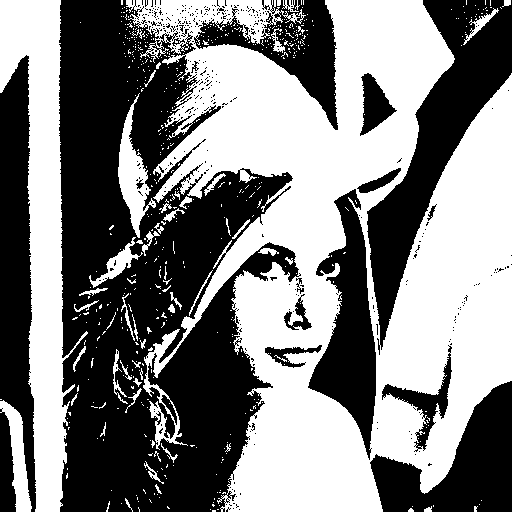

In [ ]:
dir_ = '/content/'
img3 = 'binarized_lena.bmp'
obj3 = HW2(dir_,img3)
cv2_imshow(obj3.img)

### Connected Components Algorithms


1.   An Iterative Algorithm
2.   The Classical Algorithm (Transitive Closure)
3.   A Space-Efficient Two-Pass Algorithm That Uses a Local Equivalence Table
4.   An Efficient Run-Length Implementation of the Local Equivalence Table Method

####1. An Iterative Algorithm
 - Step 1. initialization of each pixel to a unique label
 - Step 2. iteration of top-down followed by bottom-up passes until no change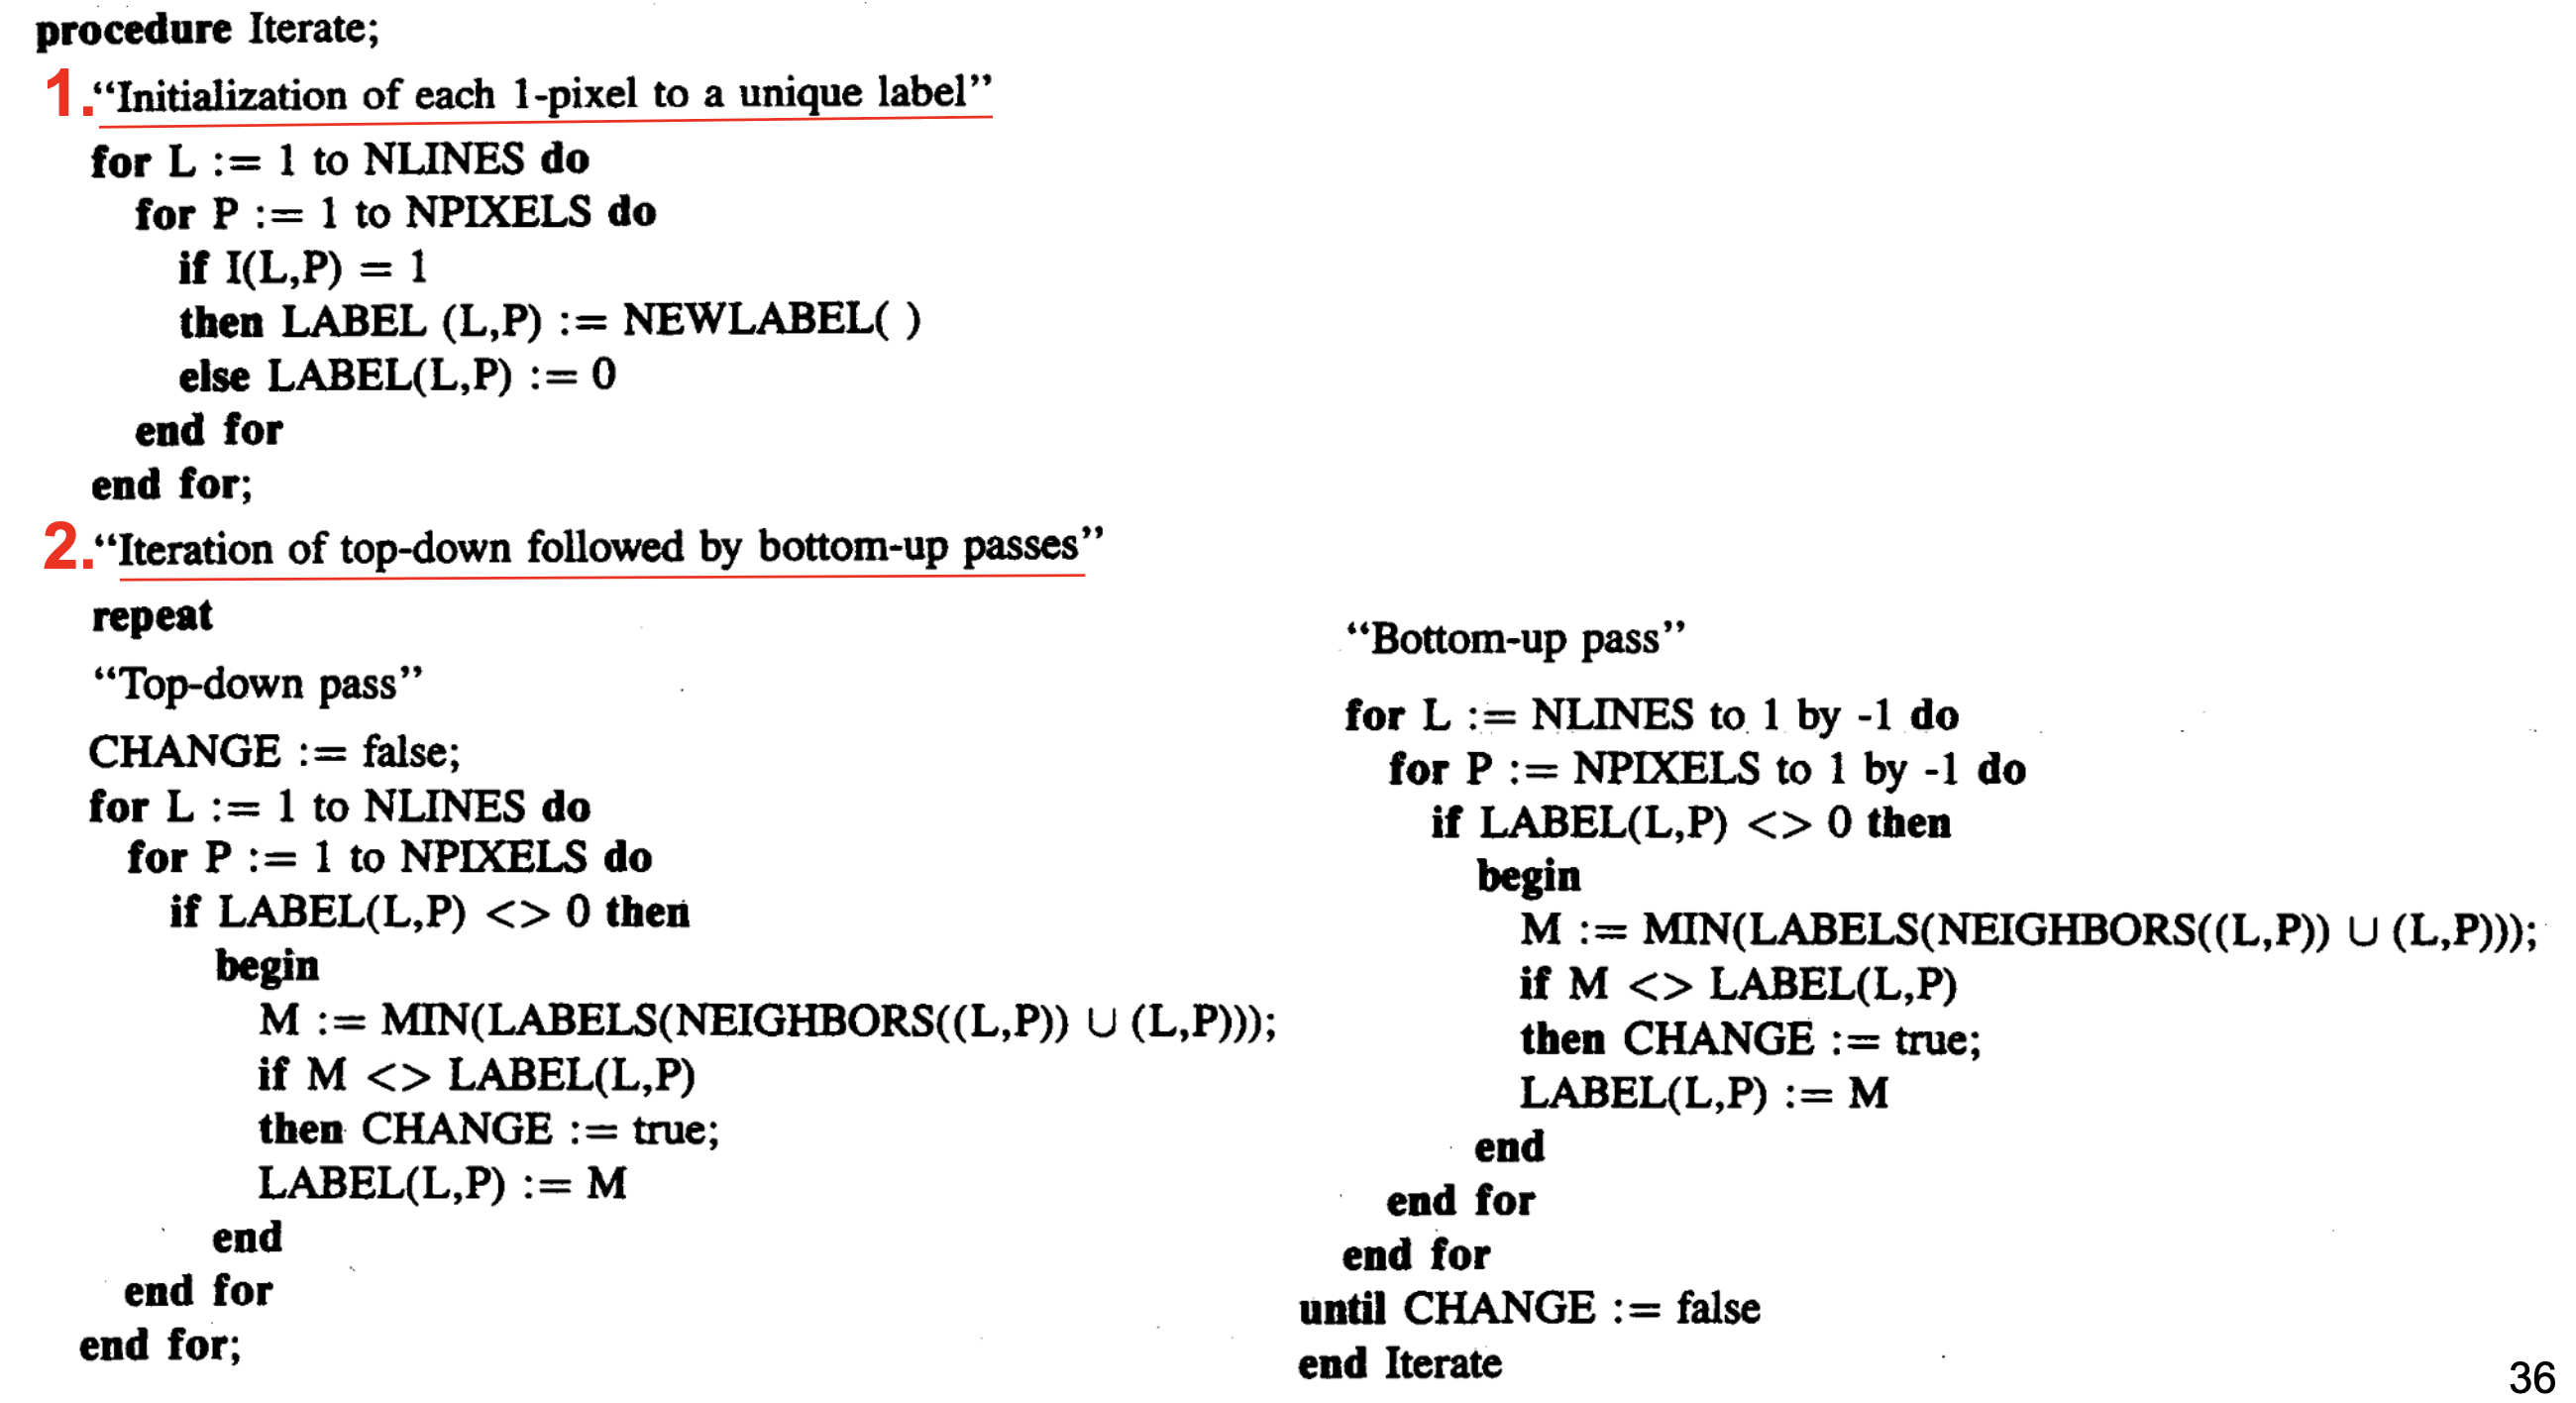

In [ ]:
obj3.iterateAlgorithm()

Number of iterations = 1
top down!!!
buttom up!!!
Number of iterations = 2
top down!!!
buttom up!!!
Number of iterations = 3
top down!!!
buttom up!!!
Number of iterations = 4
top down!!!
buttom up!!!
Number of iterations = 5
top down!!!
buttom up!!!
Number of iterations = 6
top down!!!
buttom up!!!
Number of iterations = 7
top down!!!
buttom up!!!
Number of iterations = 8
top down!!!
buttom up!!!
Number of iterations = 9
top down!!!
buttom up!!!
Number of iterations = 10
top down!!!
buttom up!!!
Number of iterations = 11
top down!!!
buttom up!!!
Number of iterations = 12
top down!!!
buttom up!!!
Number of iterations = 13
top down!!!
buttom up!!!
Number of iterations = 14
top down!!!
buttom up!!!
Number of iterations = 15
top down!!!
buttom up!!!
Number of iterations = 16
top down!!!
buttom up!!!
Number of iterations = 17
top down!!!
buttom up!!!
Number of iterations = 18
top down!!!
buttom up!!!
Number of iterations = 19
top down!!!
buttom up!!!
Number of iterations = 20
top down!!!
bu

 - Q1: 畫十字、bounding box的部分可否直接call library?
>可以哦。 e.g. cv2.rectangle 標示重心也可以用其他圖案標示像是實心圓等圖案，不一定要用十字，標示清楚即可。

We used the [rectangle()](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga07d2f74cadcf8e305e810ce8eed13bc9) to draw the bounding box.
We used the [cv2.line()](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2) to draw the cross at the centroid of each region.

 - Q4: (c)的結果圖bounding box 應該會有幾個?
>無論是4連通、8連通都是五個bounding box，請繳交之前再次確認。 如果你的結果不是五個應該是你的程式寫錯或是你用面積500以外的數值來過濾conneted component。

 - Q5: 畫十字在重心是要依照第三周教的那個方法畫在所有相同label的重心，還是畫在框住相同label的最小矩形正中間即可?
>相同label之重心，不是矩形正中間。
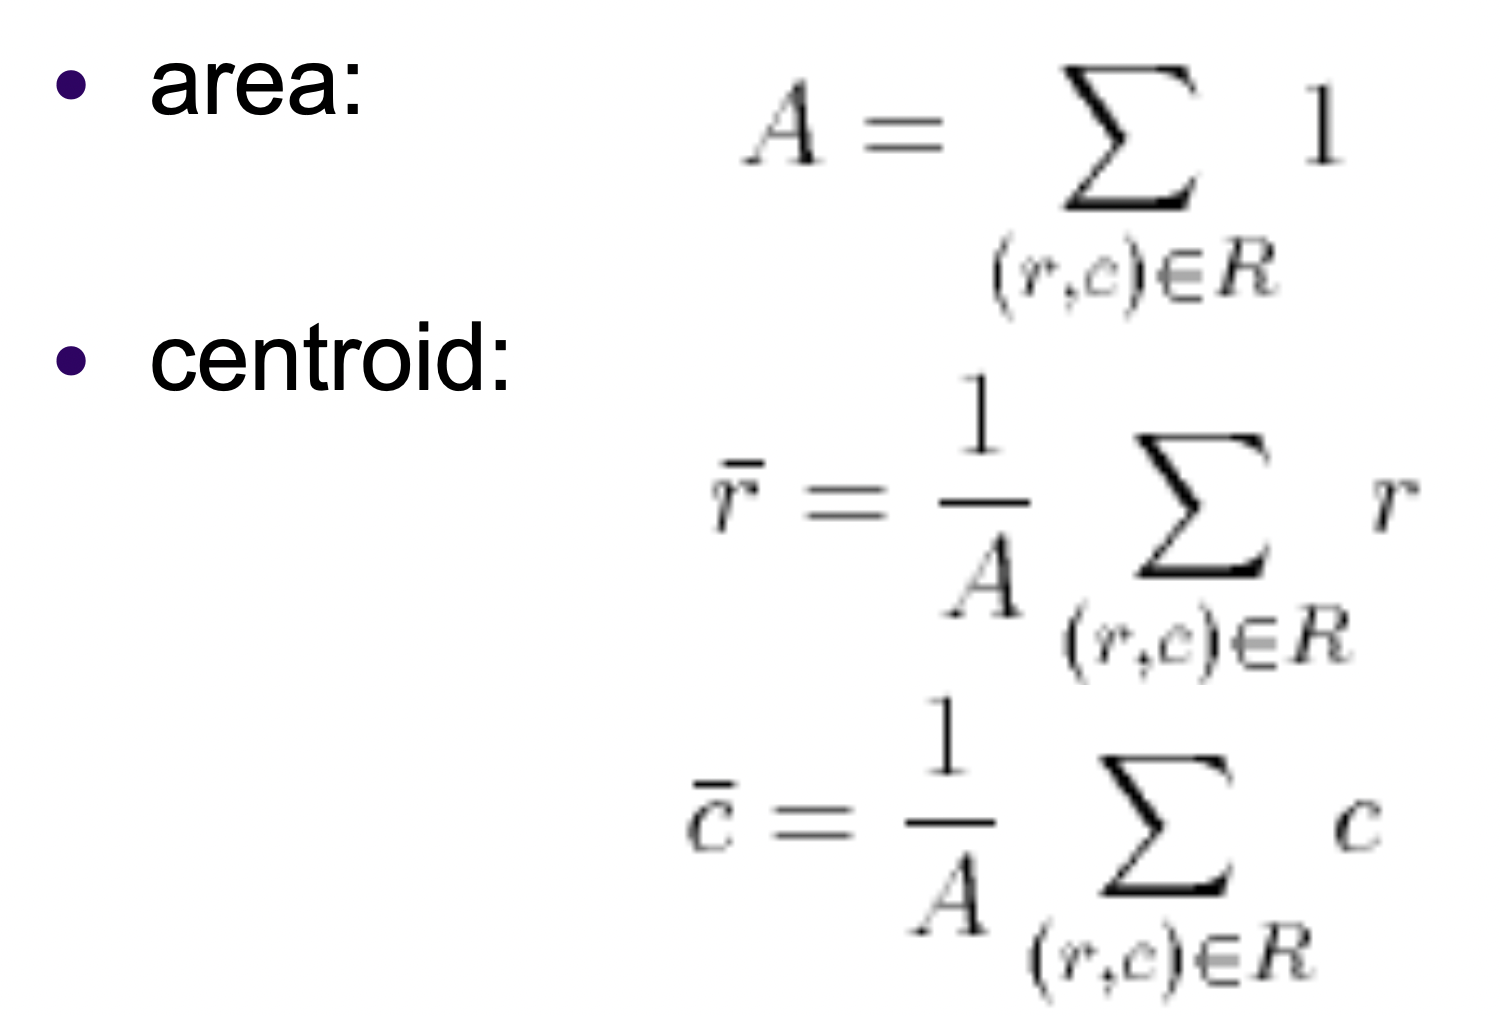

In [ ]:
a = obj3.boundingBox()

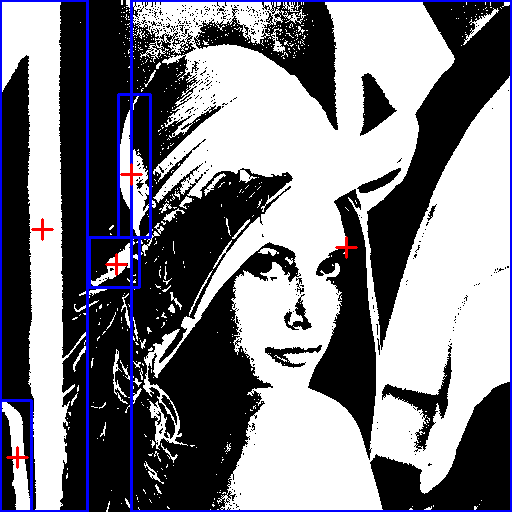

In [ ]:
cv2_imshow(a)